In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height: 999999999999 in;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [2]:
%matplotlib inline
import itertools
import os
import os.path as osp

from IPython.display import display, Image, Markdown
from ipywidgets import interact, interactive
import ipywidgets as widgets 
import matplotlib
import matplotlib.pylab as plt
import matplotlib.font_manager as font_manager
import numpy as np
import pickle

from attackgraph import settings
import attackgraph.soccer.qmixing_main


# Set the font to match AAMAS.
import matplotlib.font_manager as font_manager
font_dirs = ["/Users/max/Library/Fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
matplotlib.rcParams['font.family'] = "Linux Libertine O"


np.set_printoptions(precision=2)
RESULTS_DIR = settings.get_results_dir()

In [3]:
def parse_metrics_from_output(run_name: str):
    """ Collects the numerical performance of a job from the output log.
    
    :param run_name: Run name.
    :type run_name: str
    """    
    metrics = {}
    filepath = osp.join(RESULTS_DIR, run_name, "out.log")
    print(f"Loading: {filepath}")
    with open(filepath, "r") as output:
        log = [x.strip() for x in output.readlines()]
        
    # Collect the QMix results.
    # These are all contained in log lines of the structure:
    # 2019-10-21 16:38:55,663 attackgraph INFO   - Opponent 0 vs. QMix: -100.0, 0.0
    metrics["QMix"] = {}
    print("  QMix: ")
    for line in log:
        if "QMix:" not in line or "Opponent" not in line:
            continue
            
        tokens = line.split(' ')
        opponent_id = int(tokens[8])
        mean = float(tokens[-2].strip(','))
        std = float(tokens[-1])
        
        metrics["QMix"][opponent_id] = (mean, std)
        print(f"    - {opponent_id}: {mean}, {std}")
        
    # Collect the BR(Mixture) results.
    # These are all contained in log lines of the structure:
    # 2019-10-21 16:39:18,186 attackgraph INFO   - Opponent 0 vs. MixtureBR: 100.0, 0.0
    metrics["BR(Mixture)"] = {}
    print("  BR(Mixture): ")
    for line in log:
        if "MixtureBR:" not in line or "Opponent" not in line:
            continue
            
        tokens = line.split(' ')
        opponent_id = int(tokens[8])
        mean = float(tokens[-2].strip(','))
        std = float(tokens[-1])
        
        metrics["BR(Mixture)"][opponent_id] = (mean, std)
        print(f"    - {opponent_id}: {mean}, {std}")

    return metrics
        

In [4]:
metrics = [parse_metrics_from_output(f"10_22_soccer_{i}") for i in range(5)]

Loading: /Users/max/projects/attack_graph/attackgraph/../results/10_22_soccer_0/out.log
  QMix: 
    - 0: 100.0, 0.0
    - 1: 100.0, 0.0
    - 2: 100.0, 0.0
    - 3: 100.0, 0.0
    - 4: 100.0, 0.0
  BR(Mixture): 
    - 0: 24.0, 97.07728879609277
    - 1: 94.4, 32.994545003682056
    - 2: 16.0, 98.71170143402453
    - 3: -100.0, 0.0
    - 4: -100.0, 0.0
Loading: /Users/max/projects/attack_graph/attackgraph/../results/10_22_soccer_1/out.log
  QMix: 
    - 0: 100.0, 0.0
    - 1: 100.0, 0.0
    - 2: 100.0, 0.0
    - 3: 100.0, 0.0
    - 4: 100.0, 0.0
  BR(Mixture): 
    - 0: 100.0, 0.0
    - 1: 88.0, 47.49736834815167
    - 2: 100.0, 0.0
    - 3: 100.0, 0.0
    - 4: 100.0, 0.0
Loading: /Users/max/projects/attack_graph/attackgraph/../results/10_22_soccer_2/out.log
  QMix: 
    - 0: -100.0, 0.0
    - 1: 92.8, 37.25801927102404
    - 2: 100.0, 0.0
    - 3: 100.0, 0.0
    - 4: 100.0, 0.0
  BR(Mixture): 
    - 0: 100.0, 0.0
    - 1: 100.0, 0.0
    - 2: -51.2, 85.89854480723174
    - 3: -100.0, 0

In [5]:
# We now need to generate a set of evaluation mixtures.
mix_coefficients = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# That have a maximum total of 1.
opponent_mixtures = []
for c1, c2, c3, c4, c5 in itertools.product(mix_coefficients, repeat=5):
    if c1 + c2 + c3 + c4 + c5 == 1.0:
        opponent_mixtures += [np.array([c1, c2, c3, c4, c5])]

print(f"Found {len(opponent_mixtures)} valid mixtures.")

Found 860 valid mixtures.


In [6]:
# Estimate the performance of both QMix and BR(Mixture) on the various opponent's strategies.
qmix_means = []
qmix_stds = []

br_means = []
br_stds = []

for mixture in opponent_mixtures:
    
    qmix_result_means = []
    qmix_result_stds = []
    
    br_result_means = []
    br_result_stds = []
    
    for result in metrics:
        # QMix.
        result_means = np.array([result["QMix"][i][0] for i in range(5)])
        result_stds = np.array([result["QMix"][i][1] for i in range(5)])
        qmix_result_means += [np.sum(result_means*mixture)]
        qmix_result_stds += [np.sqrt(np.sum(result_stds**2 * mixture**2))]
        
        # BR(Mixture).
        result_means = np.array([result["BR(Mixture)"][i][0] for i in range(5)])
        result_stds = np.array([result["BR(Mixture)"][i][1] for i in range(5)])
        br_result_means += [np.sum(result_means*mixture)]
        br_result_stds += [np.sqrt(np.sum(result_stds**2 * mixture**2))]

    qmix_means += [np.mean(qmix_result_means)]
    qmix_stds += [np.sqrt(np.sum(np.array(qmix_result_stds)**2))]
    
    br_means += [np.mean(br_result_means)]
    br_stds += [np.sqrt(np.sum(np.array(br_result_stds)**2))]

In [7]:
qmix_means = np.array(qmix_means)
qmix_stds = np.array(qmix_stds)

br_means = np.array(br_means)
br_stds = np.array(br_stds)

# Sort in order of best performance.
qmix_new_indices = qmix_means.argsort()[::-1]
qmix_means = qmix_means[qmix_new_indices]
qmix_stds = qmix_stds[qmix_new_indices]

br_new_indices = br_means.argsort()[::-1]
br_means = br_means[br_new_indices]
br_stds = br_stds[br_new_indices]

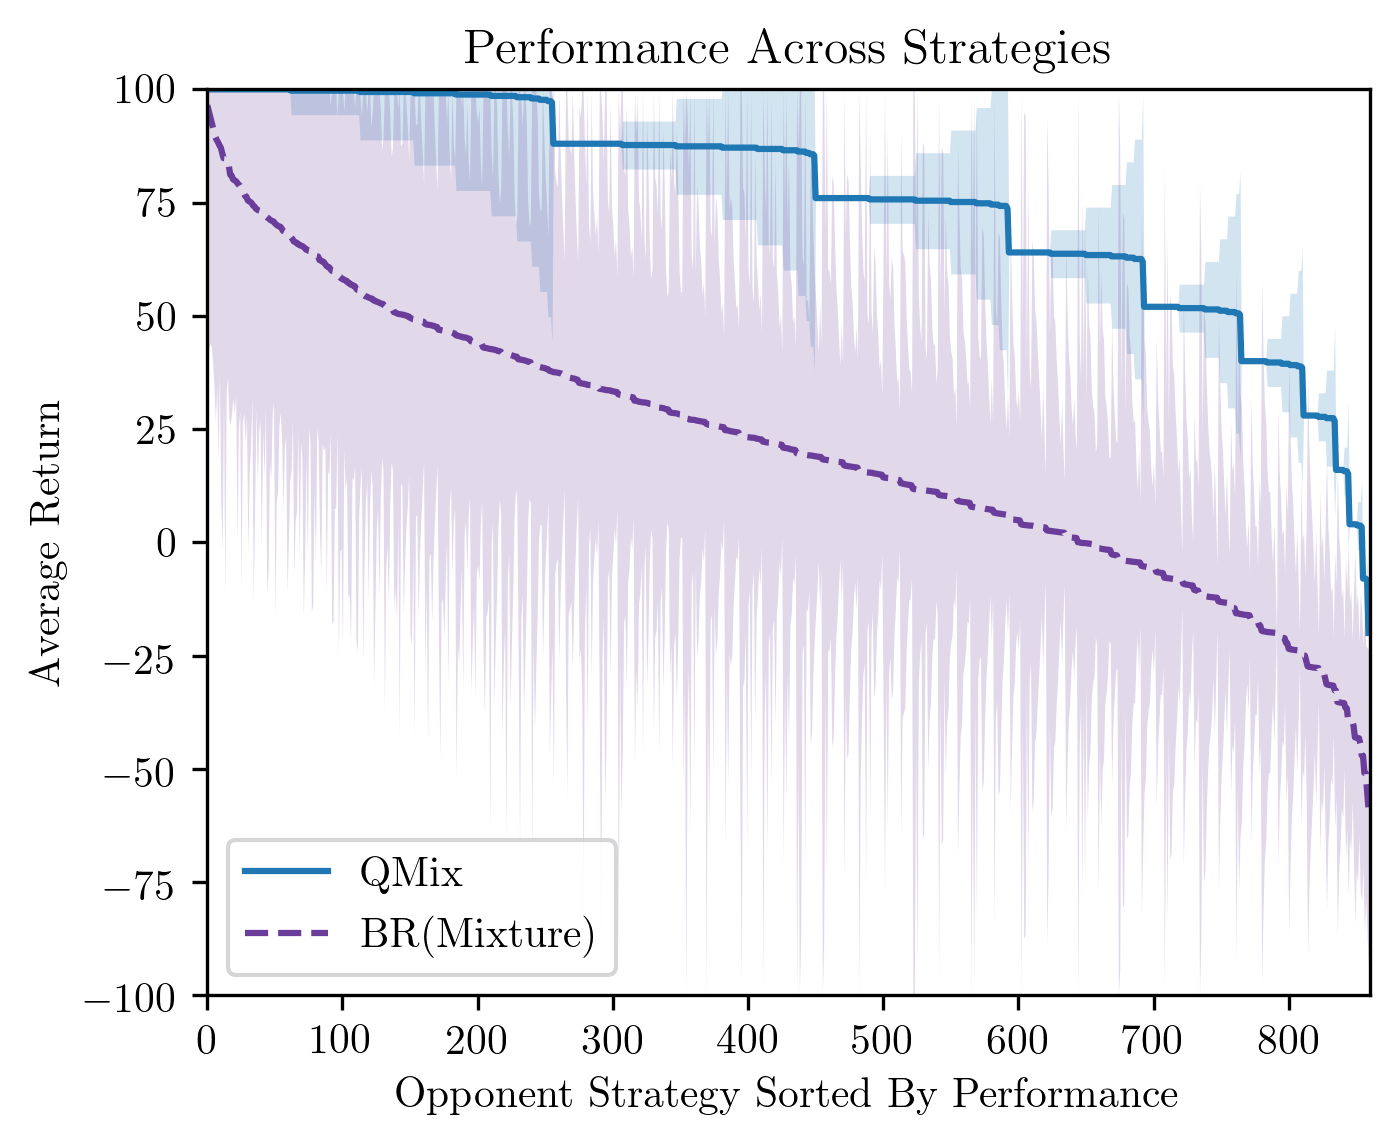

In [8]:
# Colors.
cmap = matplotlib.cm.get_cmap("Paired")
blue = cmap(0.10)
yellow = cmap(0.80)

# Plot the performance.
fig, ax = plt.subplots(figsize=(5,4), dpi=300)
xs = np.arange(len(qmix_means))

plt.plot(xs, qmix_means, label="QMix", color=blue)
plt.fill_between(
    xs, 
    np.clip(qmix_means - qmix_stds, -100, None),
    np.clip(qmix_means + qmix_stds, None, 100),
    alpha=0.2,
    color=blue,
    linewidth=0.0)


plt.plot(xs, br_means, linestyle="--", label="BR(Mixture)", color=yellow)
plt.fill_between(
    xs,
    np.clip(br_means - br_stds, -100, None),
    np.clip(br_means + br_stds, None, 100),
    alpha=0.2,
    color=yellow,
    linewidth=0.0)


ax.set_xlim([0, len(qmix_means)])
ax.set_ylim([-100, 100])

ax.set_title("Performance Across Strategies")
ax.set_ylabel("Average Return")
ax.set_xlabel("Opponent Strategy Sorted By Performance")

ax.legend(loc="lower left")
plt.show()

In [9]:
# Estimate the performance of both QMix and BR(Mixture) pure-strategies and mixed-strategy.
qmix_means = {0: [], 1: [], 2: [], 3: [], 4: []}
qmix_stds = {0: [], 1: [], 2: [], 3: [], 4: []}

br_means = {0: [], 1: [], 2: [], 3: [], 4: []}
br_stds = {0: [], 1: [], 2: [], 3: [], 4: []}
    
for result in metrics:
    for opp_i in range(5):
        # QMix.
        qmix_means[opp_i] += [result["QMix"][opp_i][0]]
        qmix_stds[opp_i] += [result["QMix"][opp_i][1]]
        
        # BR(Mixture).
        br_means[opp_i] += [result["BR(Mixture)"][opp_i][0]]
        br_stds[opp_i] += [result["BR(Mixture)"][opp_i][1]]
        
ps_qmix_means = []
ps_qmix_stds = []

ps_br_means = []
ps_br_stds = []
for opp_i in range(5):
    print(f"Opponent {opp_i}:")
    
    # QMix.
    mean = np.mean(qmix_means[opp_i])
    std = np.sqrt(np.sum(np.array(qmix_stds[opp_i])**2))
    print(f"  - QMix: {mean}, {std}")
    ps_qmix_means += [mean]
    ps_qmix_stds += [std]
    
    # BR(Mixture).
    mean = np.mean(br_means[opp_i])
    std = np.sqrt(np.sum(np.array(br_stds[opp_i])**2))
    print(f"  - BR(Mixture): {mean}, {std}")
    ps_br_means += [mean]
    ps_br_stds += [std]
    
print("Mixture:")

# QMix.
mean = np.mean(ps_qmix_means)
std = np.sqrt(np.sum(np.array(ps_qmix_stds)**2))
print(f"  - QMix: {mean}, {std}")

mean = np.mean(ps_br_means)
std = np.sqrt(np.sum(np.array(ps_br_stds)**2))
print(f"  - BR(Mixture): {mean}, {std}")

Opponent 0:
  - QMix: -20.0, 0.0
  - BR(Mixture): 84.8, 97.07728879609277
Opponent 1:
  - QMix: 97.12, 52.90897844411664
  - BR(Mixture): 96.47999999999999, 57.83286263016902
Opponent 2:
  - QMix: 100.0, 0.0
  - BR(Mixture): 19.68, 150.71031816037015
Opponent 3:
  - QMix: 100.0, 0.0
  - BR(Mixture): -20.0, 0.0
Opponent 4:
  - QMix: 100.0, 0.0
  - BR(Mixture): -58.720000000000006, 35.199999999999996
Mixture:
  - QMix: 75.424, 52.90897844411664
  - BR(Mixture): 24.447999999999997, 191.62797290583646
